# The UCI Wine Quality

### Import libraries

In [1]:
from ucimlrepo import fetch_ucirepo
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import seaborn as sns

### Preparing the datasets

In [2]:
wine_quality = fetch_ucirepo(id=186) 
X = wine_quality.data.features 
y = wine_quality.data.targets 

# Categories the wine quality into 3 categories: low (0-4), standard (5-6), and high (7-10)
y = np.where(y <= 4, '0', np.where(y <= 6, '1', '2'))

test_sizes = [.6, .4, .2, .1]
datasets = {}
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=22125, stratify=y)
    datasets[test_size] = {
        "feature_train": X_train,
        "feature_test": X_test,
        "label_train": y_train,
        "label_test": y_test
    }

### Visualizing the data

#### Histogram plot function

In [3]:
from matplotlib.axes import Axes

def plot_distribution(ax: Axes, data, title):
    unique, counts = np.unique(data, return_counts=True)
    total_count = sum(counts)
    frequencies = counts / total_count

    bars = ax.bar(unique, counts, edgecolor='black', label='Count')
    ax.set_ylabel('Count')
    ax.tick_params(axis='y')
    ax.set_xticks(unique)
    ax.set_xticklabels(['low', 'standard', 'high'])

    for bar, count, freq in zip(bars, counts, frequencies):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total_count / 569 * 5,
                f'{count} ({freq*100:.2f}%)', ha='center', color='darkgreen', fontsize=10)

    ax2 = ax.twinx()
    ax2.plot(unique, frequencies, color='red', marker=' ', linestyle=' ', label='Frequency')
    ax2.set_ylabel('Frequency')
    ax2.tick_params(axis='y')
    ax2.grid(visible=True, linestyle='--', linewidth=0.5)

    ax.set_title(title)

#### Visualizing the distribution of the target variable in each subset

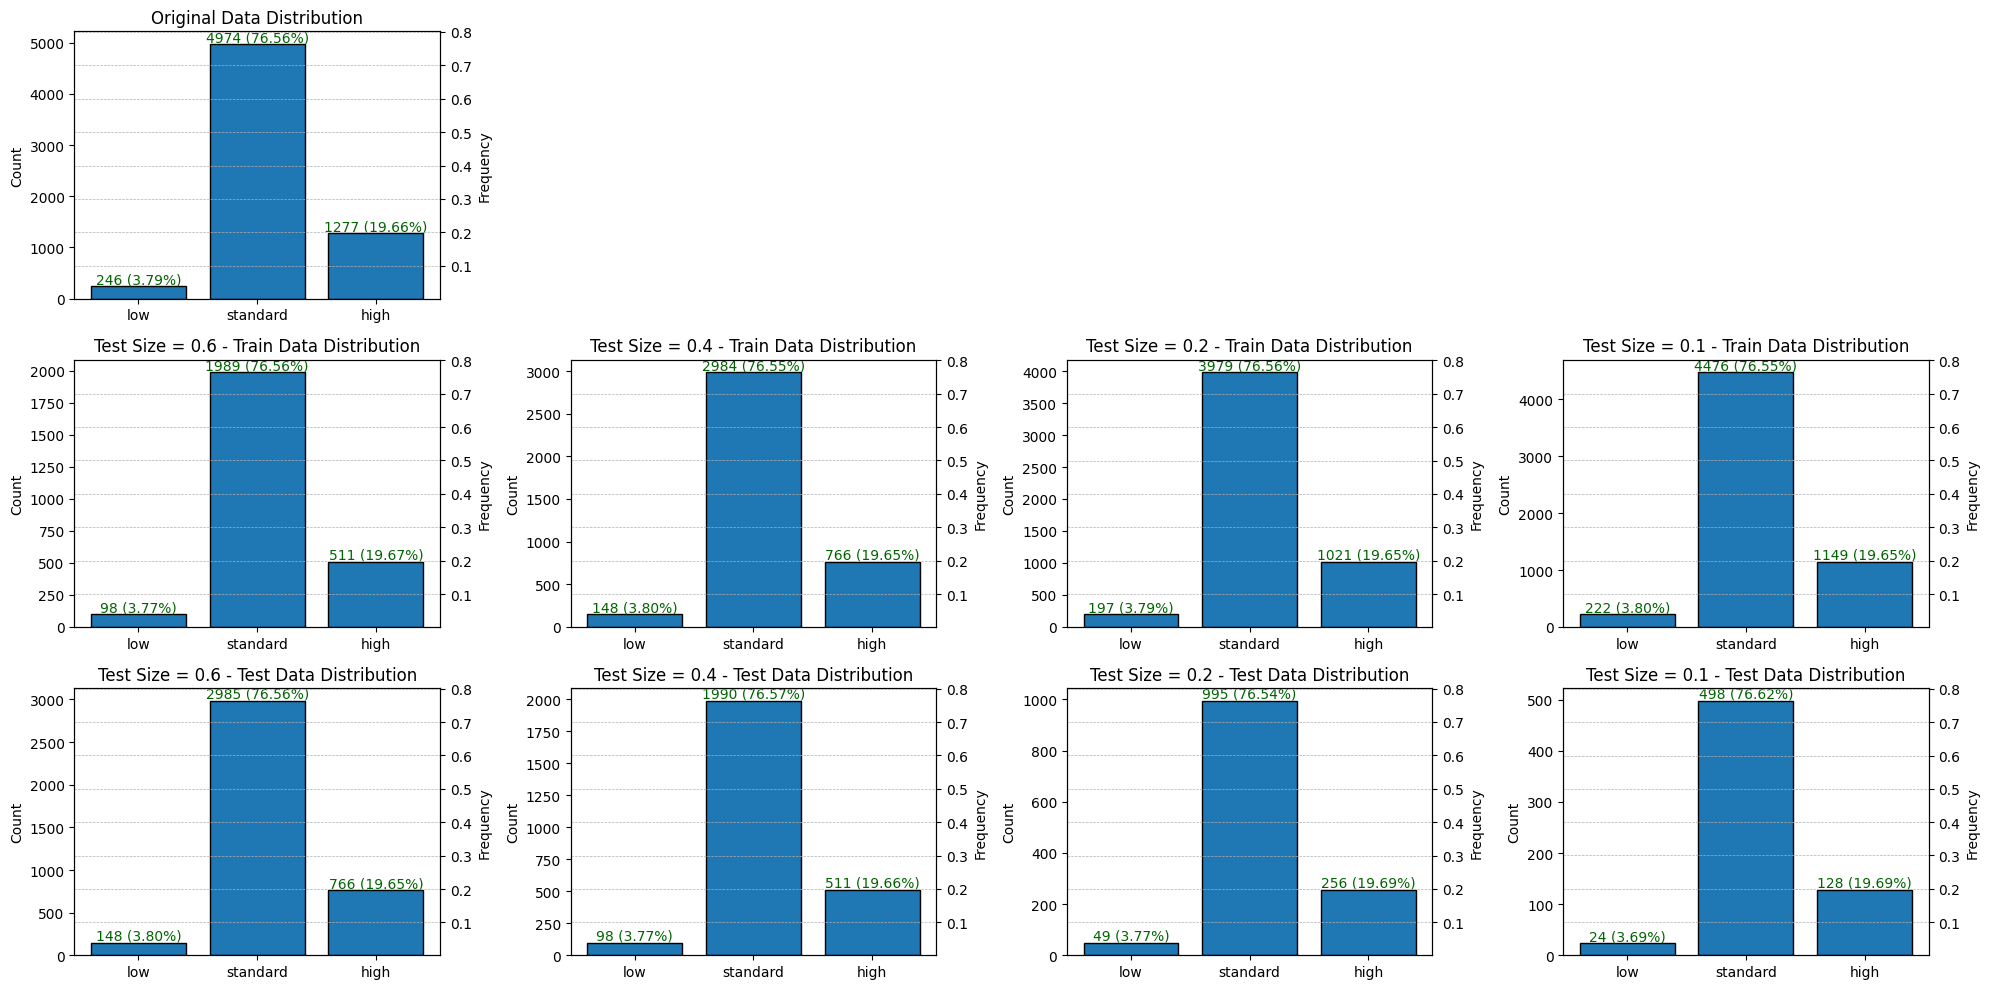

In [4]:
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(3, 4, figure=fig)

# Original data distribution
ax = fig.add_subplot(gs[0, 0])
plot_distribution(ax, y, 'Original Data Distribution')

# Data distribution for each test size
for i, (test_size, data) in enumerate(datasets.items(), 0):
    ax = fig.add_subplot(gs[1, i])
    plot_distribution(ax, data['label_train'], f'Test Size = {test_size} - Train Data Distribution')

    ax = fig.add_subplot(gs[2, i])
    plot_distribution(ax, data['label_test'], f'Test Size = {test_size} - Test Data Distribution')

plt.tight_layout()
plt.savefig('../latex/figures/wine_quality_split.pdf', format='pdf')

### Building the decision tree classifiers

#### Build trees

In [5]:
decision_trees = {
    test_size: 
        DecisionTreeClassifier(random_state=22125, criterion='entropy')
        .fit(data["feature_train"], data["label_train"])
    for test_size, data in datasets.items()
}

#### Tree visualizations

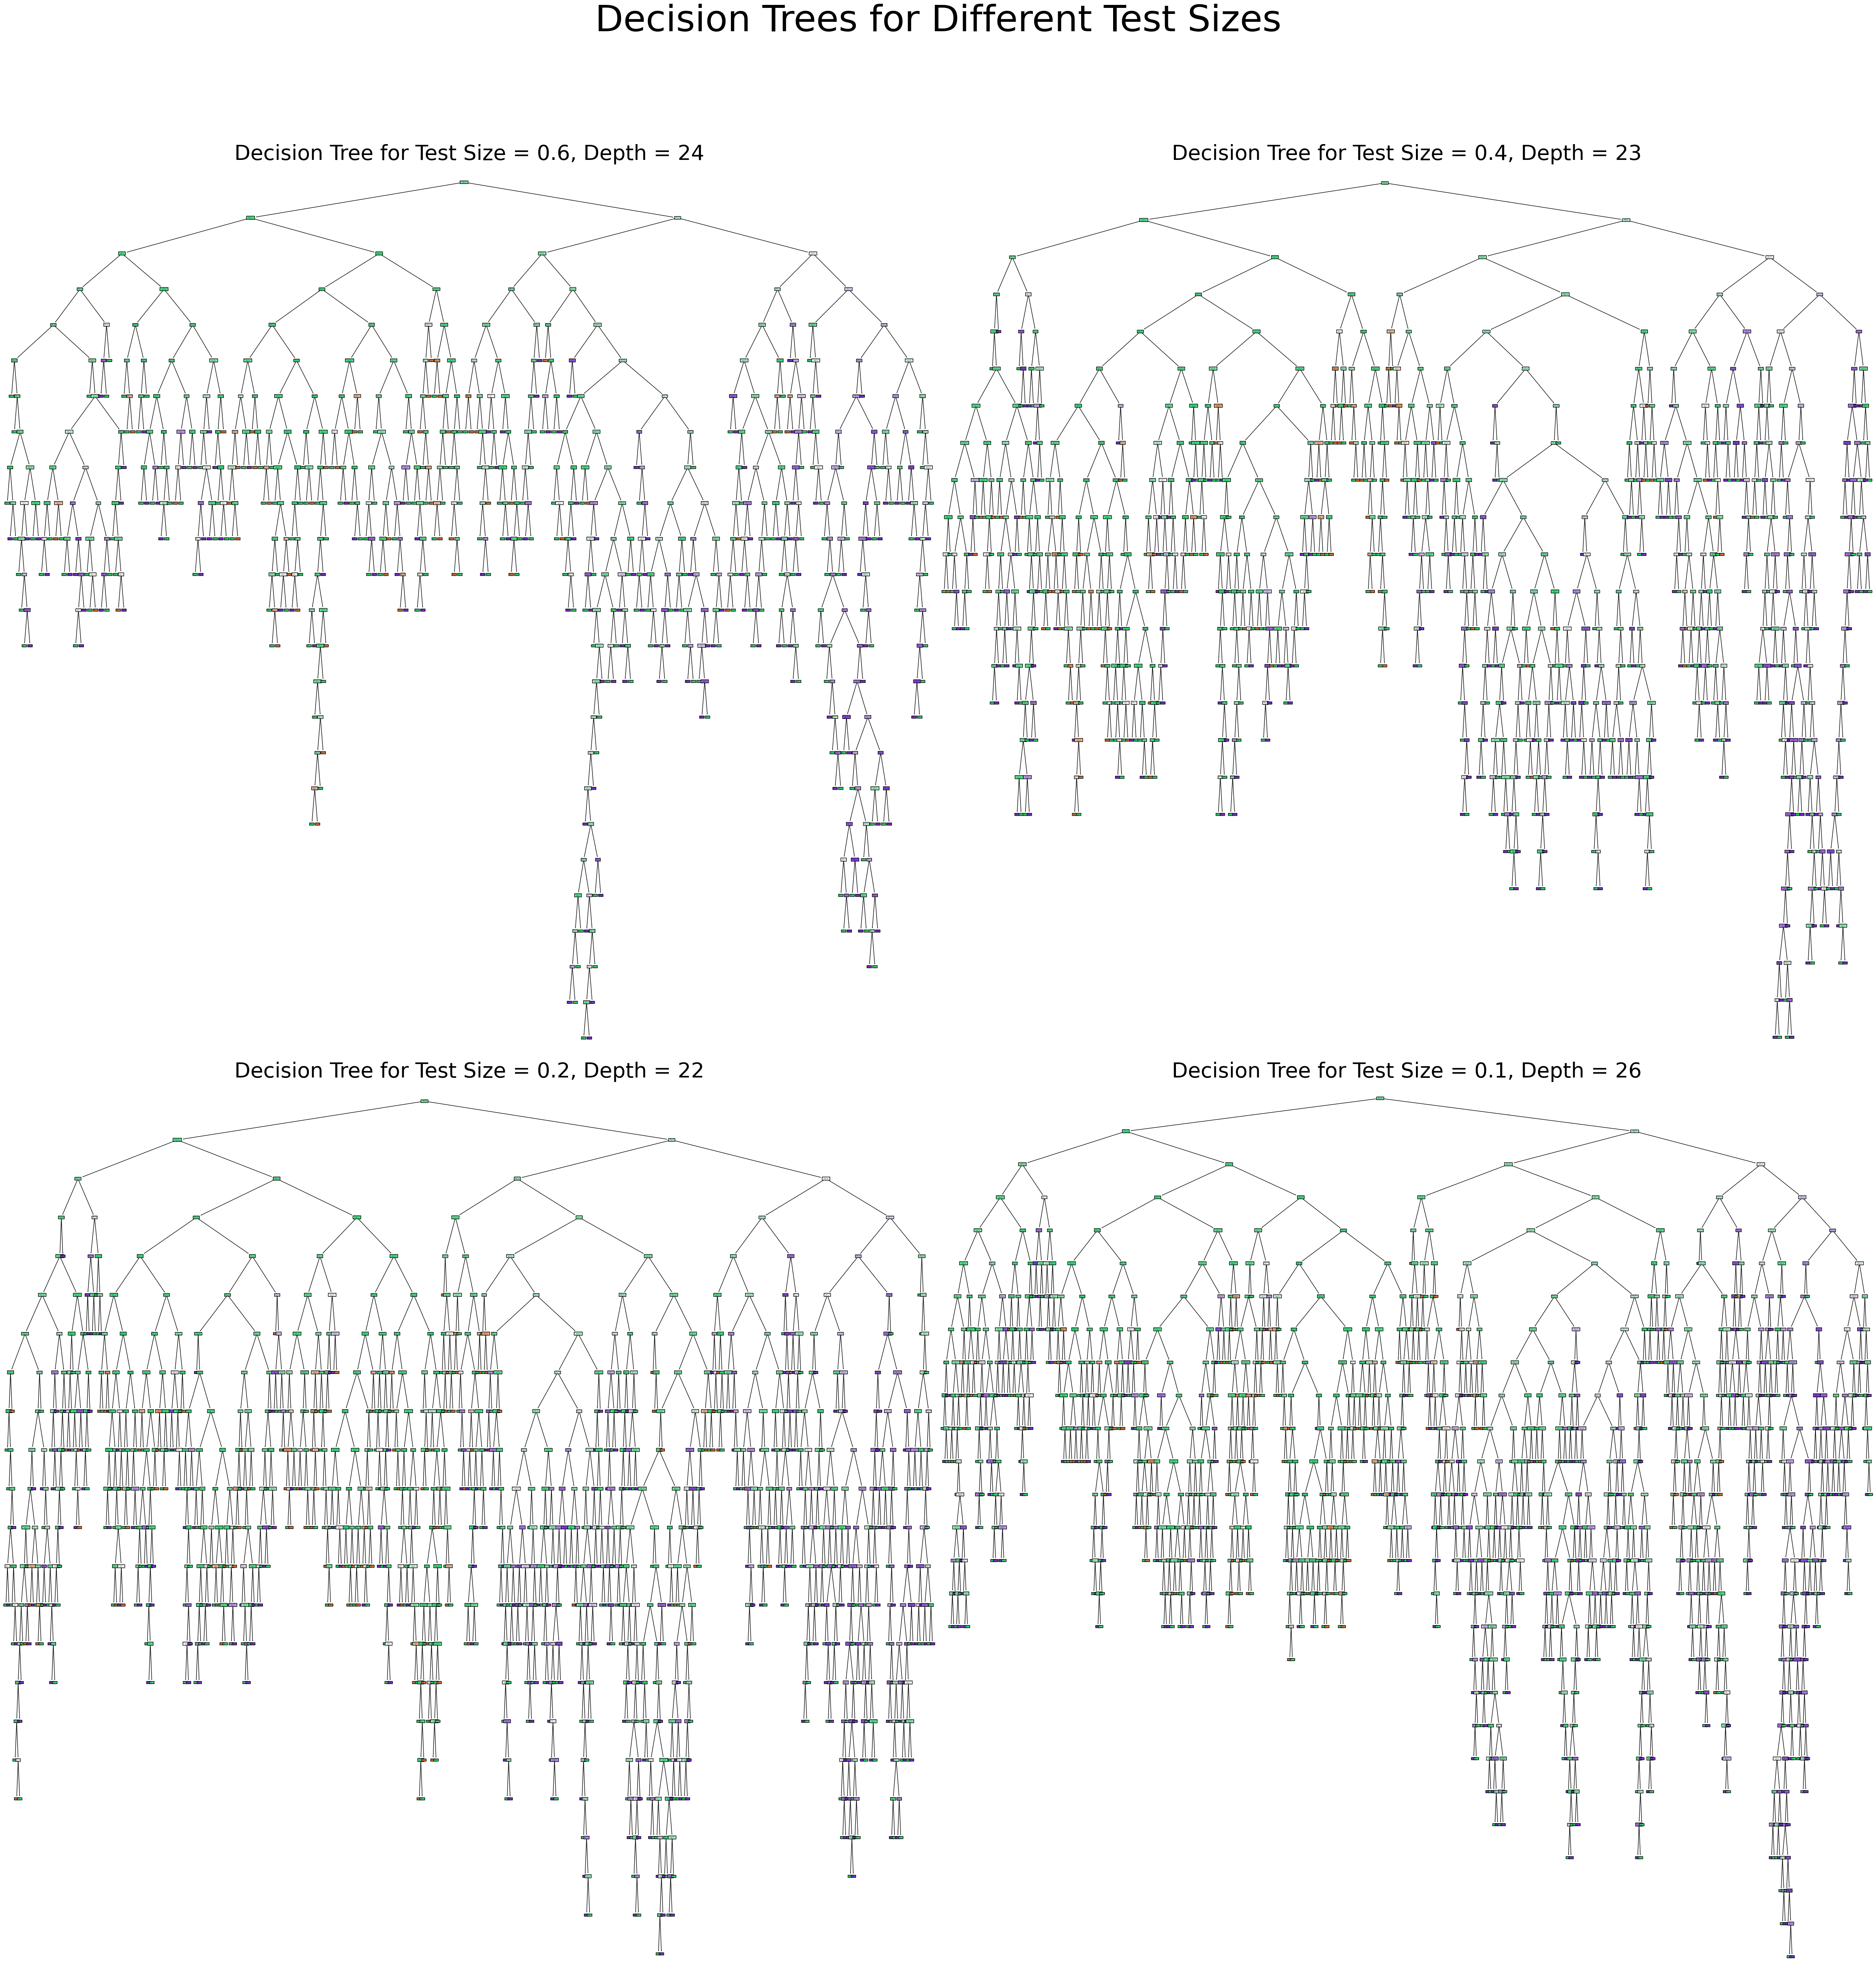

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(50, 50))

for ax, (test_size, tree) in zip(axs.ravel(), decision_trees.items()):
    plot_tree(tree, 
              feature_names=X.columns, 
              class_names=tree.classes_, 
              filled=True, 
              rounded=True, 
              ax=ax)
    ax.set_title(f'Decision Tree for Test Size = {test_size}, Depth = {tree.get_depth()}', fontsize=40)
fig.suptitle('Decision Trees for Different Test Sizes', fontsize=70, y=1.05)
plt.tight_layout()
plt.savefig('../latex/figures/wine_quality_decision_trees.pdf', format='pdf')

### Evaluating the decision tree classifiers

#### Prepare the results

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

classification_reports = {}
classification_report_dicts = {}
confusion_matrices = {}
for test_size, data in datasets.items():
    y_true = data['label_test']
    y_pred = decision_trees[test_size].predict(data['feature_test'])
    
    classification_reports[test_size] = classification_report(y_true, y_pred)
    classification_report_dicts[test_size] = classification_report(y_true, y_pred, output_dict=True)
    confusion_matrices[test_size] = confusion_matrix(y_true, y_pred)

#### Classification report

In [8]:
for test_size, classification_report_str in classification_reports.items():
    print(f'Classification Report for Test Size = {test_size}')
    print(classification_report_str)

Classification Report for Test Size = 0.6
              precision    recall  f1-score   support

           0       0.18      0.16      0.17       148
           1       0.85      0.85      0.85      2985
           2       0.53      0.55      0.54       766

    accuracy                           0.76      3899
   macro avg       0.52      0.52      0.52      3899
weighted avg       0.76      0.76      0.76      3899

Classification Report for Test Size = 0.4
              precision    recall  f1-score   support

           0       0.15      0.16      0.16        98
           1       0.85      0.86      0.85      1990
           2       0.57      0.55      0.56       511

    accuracy                           0.77      2599
   macro avg       0.52      0.52      0.52      2599
weighted avg       0.77      0.77      0.77      2599

Classification Report for Test Size = 0.2
              precision    recall  f1-score   support

           0       0.19      0.24      0.22        49
   

#### Confusion matrixes

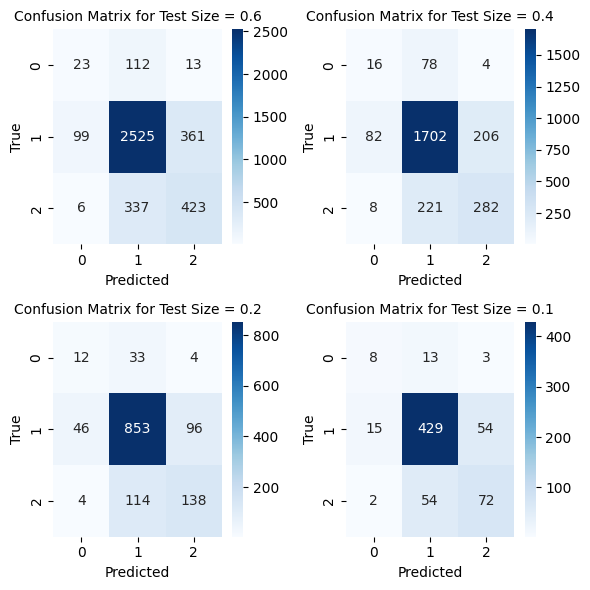

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for ax, (test_size, confusion_matrix_data) in zip(axs.ravel(), confusion_matrices.items()):
    sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for Test Size = {test_size}', fontsize=10)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    
plt.tight_layout()
plt.savefig('../latex/figures/wine_quality_confusion_matrices.pdf', format='pdf')

### The depth and accuracy of a decision tree

#### Prepare trees

In [10]:
tree = decision_trees[0.2]
dataset = datasets[0.2]
max_depth = tree.get_depth()
tree_depths = {}

tree_depths[f'None\n({max_depth})'] = tree

for i in range(2, max(max_depth + 1, 8)):
    tree = DecisionTreeClassifier(random_state=22125, criterion='entropy', max_depth=i)
    tree.fit(dataset['feature_train'], dataset['label_train'])
    tree_depths[i] = tree

#### Plot tree with different depths

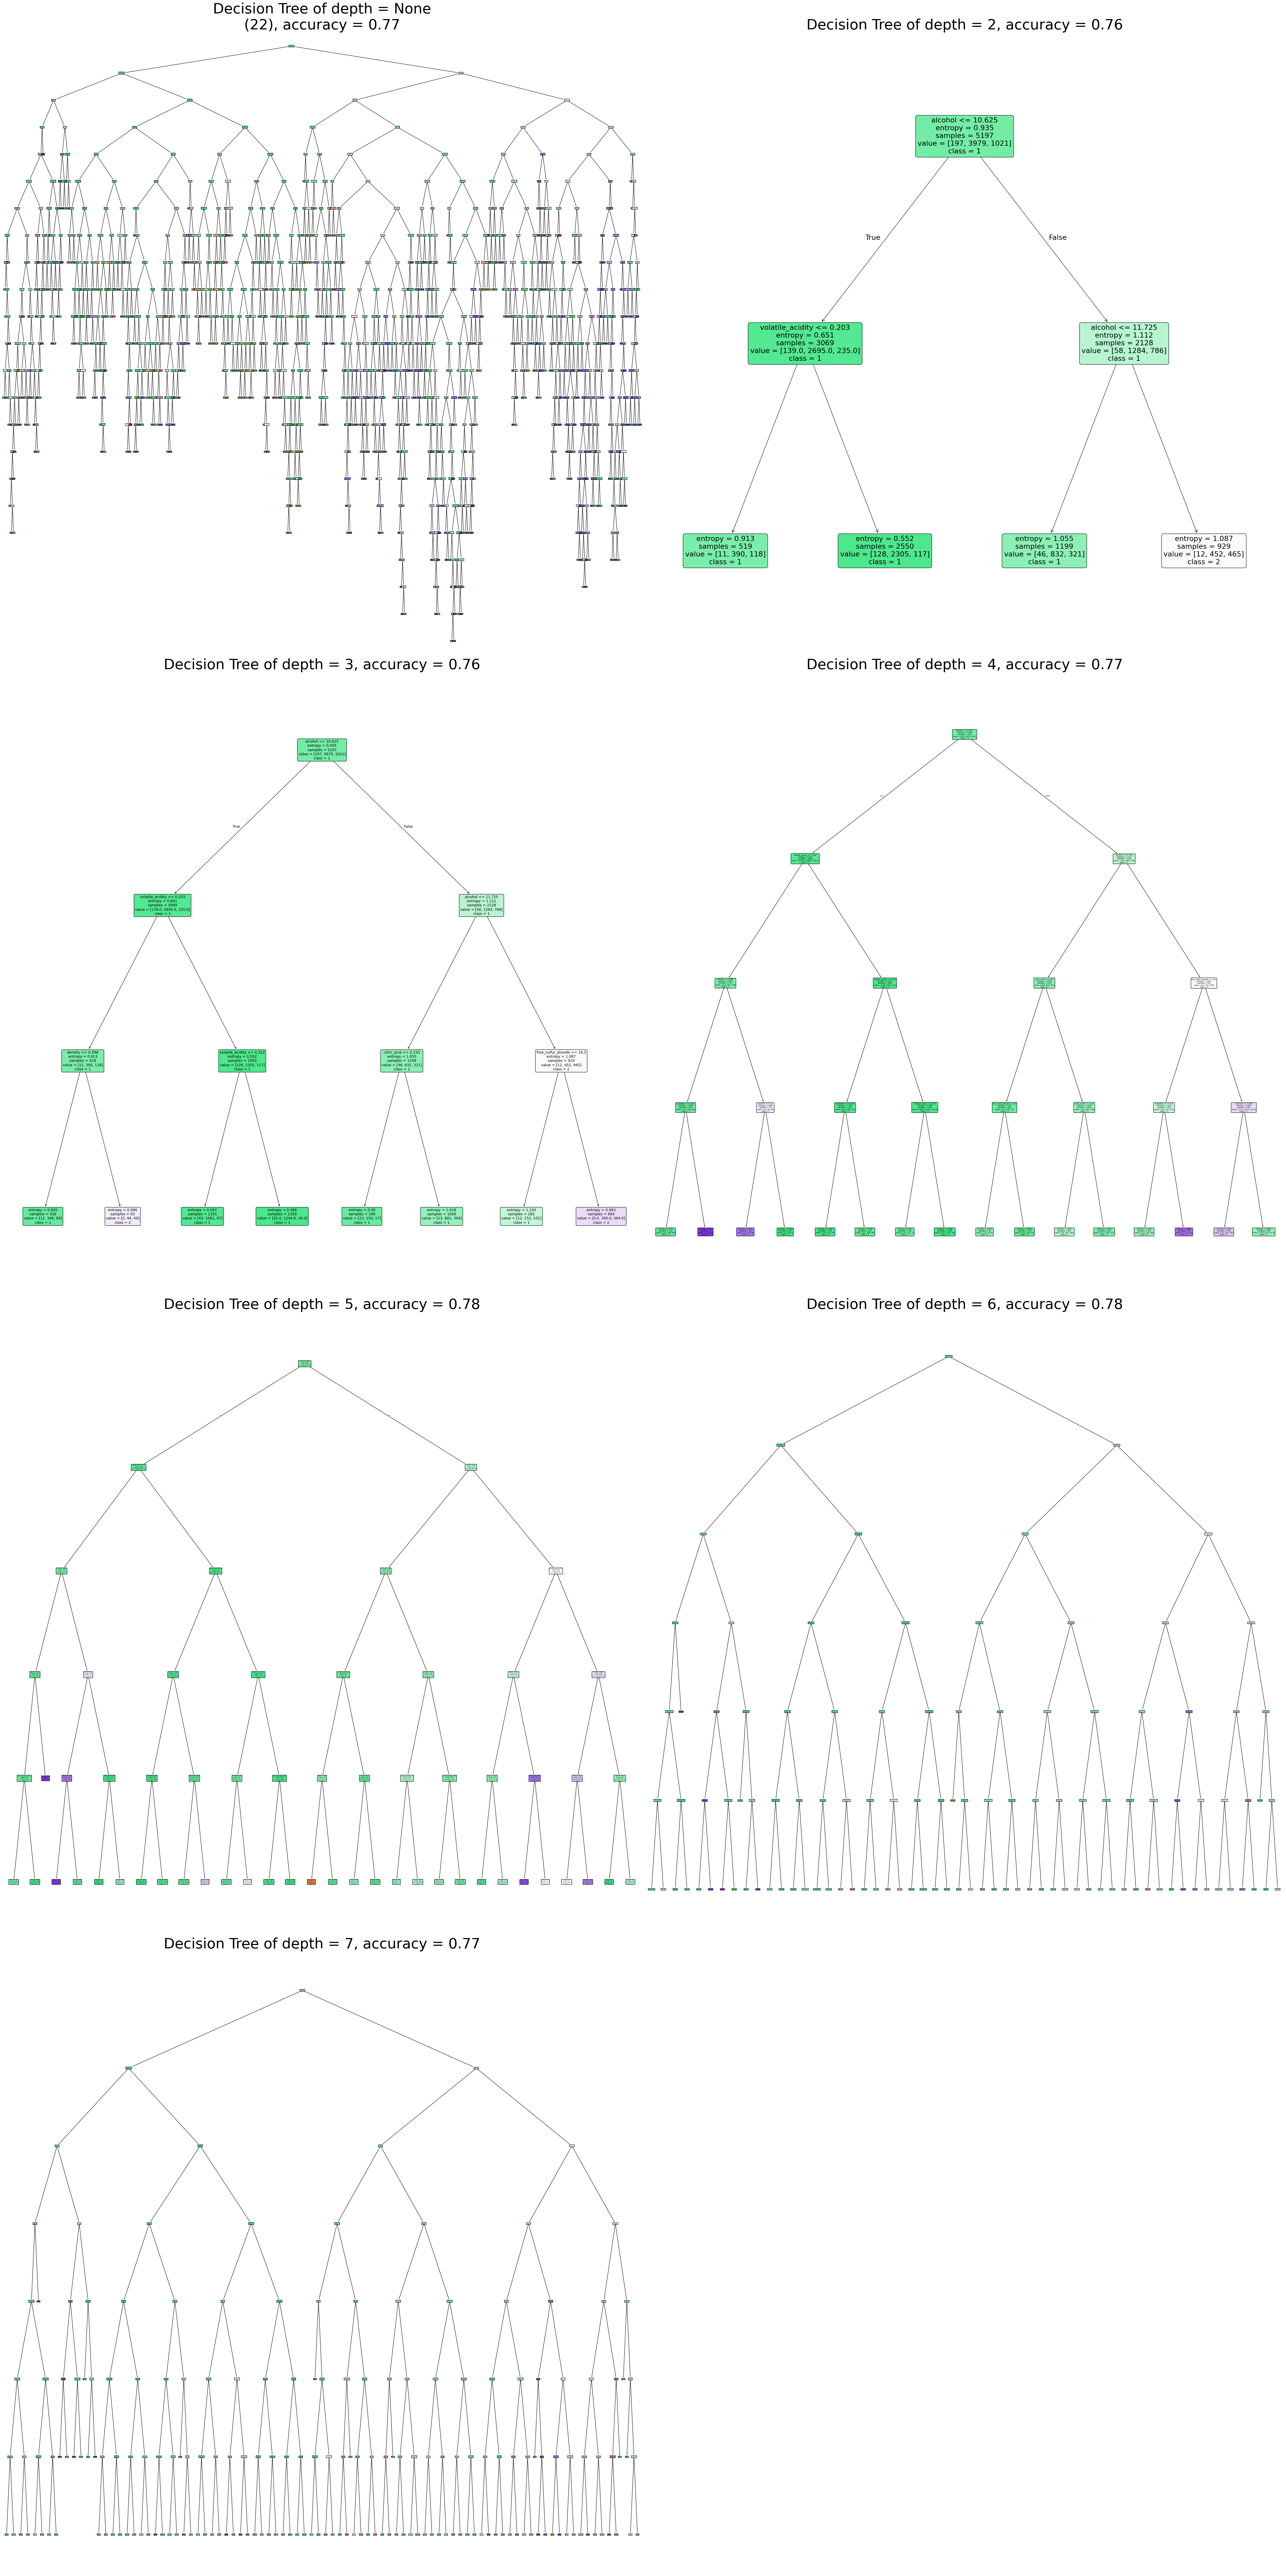

In [11]:
fig, axs = plt.subplots(4, 2, figsize=(50, 100))

for ax, (depth, tree), _ in zip(axs.ravel(), tree_depths.items(), range(7)):
    plot_tree(tree, 
              feature_names=X.columns, 
              class_names=tree.classes_, 
              filled=True, 
              rounded=True,
              ax=ax)
    ax.set_title(f'Decision Tree of depth = {depth}, accuracy = {tree.score(dataset["feature_test"], dataset["label_test"]):.2f}', fontsize=40)
axs[-1, -1].axis('off')

plt.tight_layout()

#### Plot accuracy with different depths

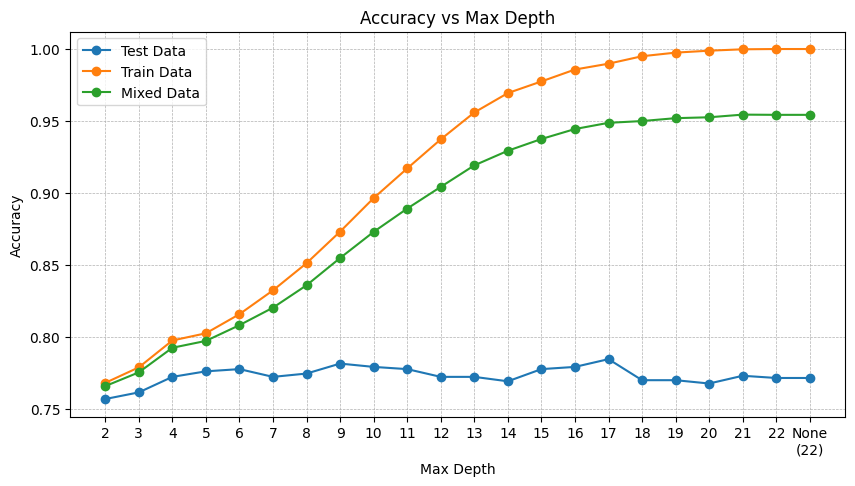

In [12]:
def get_accuracy(data_feature, data_label):
    acc = [(depth, tree.score(data_feature, data_label)) for depth, tree in tree_depths.items()]
    return acc[1:] + acc[:1]

test_data = get_accuracy(dataset['feature_test'], dataset['label_test'])
train_data = get_accuracy(dataset['feature_train'], dataset['label_train'])
mixed_data = get_accuracy(X, y)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(*zip(*test_data), label='Test Data', marker='o')
ax.plot(*zip(*train_data), label='Train Data', marker='o')
ax.plot(*zip(*mixed_data), label='Mixed Data', marker='o')
ax.set_xlabel('Max Depth')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Max Depth')
ax.legend()
ax.grid(visible=True, linestyle='--', linewidth=0.5)
plt.savefig('../latex/figures/wine_quality_accuracy_vs_max_depth.pdf', format='pdf')

### Latex helper functions

In [13]:
def latex_parse_classification_report(classification_report_dict):
    class_name_mapping = {
        '0': 'Low',
        '1': 'Standard',
        '2': 'High'
    }
    print(r"""\begin{tabular}{lcccccc}
\hline
 & \textbf{Precision} & \textbf{Recall} & \textbf{F1-score} & \textbf{Support} \\
\hline""")
    for class_name, class_report in classification_report_dict.items():
        if class_name in ['accuracy', 'macro avg', 'weighted avg']:
            continue
        print(f'{class_name_mapping[class_name]} & {class_report["precision"]:.2f} & {class_report["recall"]:.2f} & {class_report["f1-score"]:.2f} & {class_report["support"]:.0f} \\\\')
    print(
r"""\hline
\textbf{Accuracy} & & & <f1-acc> & <support-acc> \\
\textbf{Macro avg} & <f1-macro-avg> & <recall-macro-avg> & <precision-macro-avg> & <support-macro-avg> \\
\textbf{Weighted avg} & <f1-weighted-avg> & <recall-weighted-avg> & <precision-weighted-avg> & <support-weighted-avg> \\
\hline
\end{tabular}"""\
    .replace('<f1-acc>', f'{classification_report_dict["accuracy"]:.2f}')\
    .replace('<support-acc>', f'{classification_report_dict["macro avg"]["support"]:.0f}')\
    .replace('<f1-macro-avg>', f'{classification_report_dict["macro avg"]["f1-score"]:.2f}')\
    .replace('<recall-macro-avg>', f'{classification_report_dict["macro avg"]["recall"]:.2f}')\
    .replace('<precision-macro-avg>', f'{classification_report_dict["macro avg"]["precision"]:.2f}')\
    .replace('<support-macro-avg>', f'{classification_report_dict["macro avg"]["support"]:.0f}')\
    .replace('<f1-weighted-avg>', f'{classification_report_dict["weighted avg"]["f1-score"]:.2f}')\
    .replace('<recall-weighted-avg>', f'{classification_report_dict["weighted avg"]["recall"]:.2f}')\
    .replace('<precision-weighted-avg>', f'{classification_report_dict["weighted avg"]["precision"]:.2f}')\
    .replace('<support-weighted-avg>', f'{classification_report_dict["weighted avg"]["support"]:.0f}')
)

In [14]:
# latex_parse_classification_report(classification_report_dicts[0.6])
first = True
for test_size, classification_report_dict in classification_report_dicts.items():
    if first: first = False
    else: print(r'''
\vspace{2em}
''')
    print(r'\textbf{Classification Report for Test Size = <test-size>}'.replace('<test-size>', str(test_size)))
    print()
    latex_parse_classification_report(classification_report_dict)

\textbf{Classification Report for Test Size = 0.6}

\begin{tabular}{lcccccc}
\hline
 & \textbf{Precision} & \textbf{Recall} & \textbf{F1-score} & \textbf{Support} \\
\hline
Low & 0.18 & 0.16 & 0.17 & 148 \\
Standard & 0.85 & 0.85 & 0.85 & 2985 \\
High & 0.53 & 0.55 & 0.54 & 766 \\
\hline
\textbf{Accuracy} & & & 0.76 & 3899 \\
\textbf{Macro avg} & 0.52 & 0.52 & 0.52 & 3899 \\
\textbf{Weighted avg} & 0.76 & 0.76 & 0.76 & 3899 \\
\hline
\end{tabular}

\vspace{2em}

\textbf{Classification Report for Test Size = 0.4}

\begin{tabular}{lcccccc}
\hline
 & \textbf{Precision} & \textbf{Recall} & \textbf{F1-score} & \textbf{Support} \\
\hline
Low & 0.15 & 0.16 & 0.16 & 98 \\
Standard & 0.85 & 0.86 & 0.85 & 1990 \\
High & 0.57 & 0.55 & 0.56 & 511 \\
\hline
\textbf{Accuracy} & & & 0.77 & 2599 \\
\textbf{Macro avg} & 0.52 & 0.52 & 0.52 & 2599 \\
\textbf{Weighted avg} & 0.77 & 0.77 & 0.77 & 2599 \\
\hline
\end{tabular}

\vspace{2em}

\textbf{Classification Report for Test Size = 0.2}

\begin{tabular}

In [15]:
for test_size, confusion_matrix_data in confusion_matrices.items():
    print(f"Confusion Matrix for Test Size = {test_size}:\n{confusion_matrix_data}")

Confusion Matrix for Test Size = 0.6:
[[  23  112   13]
 [  99 2525  361]
 [   6  337  423]]
Confusion Matrix for Test Size = 0.4:
[[  16   78    4]
 [  82 1702  206]
 [   8  221  282]]
Confusion Matrix for Test Size = 0.2:
[[ 12  33   4]
 [ 46 853  96]
 [  4 114 138]]
Confusion Matrix for Test Size = 0.1:
[[  8  13   3]
 [ 15 429  54]
 [  2  54  72]]


In [16]:
# First feature of each decision tree
for test_size, tree in decision_trees.items():
    print(f"First feature of Decision Tree for Test Size = {test_size}: {X.columns[tree.tree_.feature[0]]}, entropy = {tree.tree_.impurity[0]:.5f}, samples = {tree.tree_.n_node_samples[0]}, threshold = {tree.tree_.threshold[0]:.2f}")

First feature of Decision Tree for Test Size = 0.6: alcohol, entropy = 0.93483, samples = 2598, threshold = 10.62
First feature of Decision Tree for Test Size = 0.4: alcohol, entropy = 0.93555, samples = 3898, threshold = 10.62
First feature of Decision Tree for Test Size = 0.2: alcohol, entropy = 0.93518, samples = 5197, threshold = 10.62
First feature of Decision Tree for Test Size = 0.1: alcohol, entropy = 0.93555, samples = 5847, threshold = 10.62


In [17]:
# accuracy of each max depth
for (depth, tree), _ in zip(tree_depths.items(), range(7)):
    print(f"Accuracy of Decision Tree with Max Depth = {depth}: {tree.score(dataset['feature_test'], dataset['label_test']):.2f}")

Accuracy of Decision Tree with Max Depth = None
(22): 0.77
Accuracy of Decision Tree with Max Depth = 2: 0.76
Accuracy of Decision Tree with Max Depth = 3: 0.76
Accuracy of Decision Tree with Max Depth = 4: 0.77
Accuracy of Decision Tree with Max Depth = 5: 0.78
Accuracy of Decision Tree with Max Depth = 6: 0.78
Accuracy of Decision Tree with Max Depth = 7: 0.77
